<a href="https://colab.research.google.com/github/TheRadDani/Sentiment-Analysis/blob/main/Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [3]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [ ]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [ ]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
train_data["text"]

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [ ]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [ ]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_data['tokens']

In [ ]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [ ]:
valid_data

Dataset({
    features: ['text', 'label', 'tokens', 'length'],
    num_rows: 6250
})

In [ ]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [ ]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [ ]:
unk_index, pad_index

(0, 1)

In [ ]:
vocab.set_default_index(unk_index)

In [ ]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [ ]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [ ]:
train_data

Dataset({
    features: ['text', 'label', 'tokens', 'length', 'ids'],
    num_rows: 18750
})

In [ ]:
train_data[0]

{'label': tensor(1),
 'length': tensor(135),
 'ids': tensor([  180,     4,    14,    10,   191,   841,    34,     7,     2,   121,
            98,   816,    50,     8,  1516,     2,   380,     7,     2,   184,
             3,     8,   805,    14,    18,    10,     8,   805,  2246,   429,
             3,    12,   347,    15,     2,   388,  1025,     9,    16,    76,
             5,    64,     7, 11198,     3,     2,  9212,    17,   761,     4,
          7812,  5460,   198,    37,     4,     6,  3653,  3683,    17,   226,
             5, 11893,     3,    53,     7,    15,  3310,   354,     5,   689,
             4,     0,  5471,     3,  2706,  3826,     9,    16,   246,    13,
            14,    18,  1111,    33,    17,   126,   188,     8,    35,   597,
           181,    19,     5,    34,  3942,  1381,    13,     2,  5370,     3,
            32,  4228,    10,    41,  2825,     8,    37,     3,     2,  4411,
          1141,   213,  2655,     6, 16946,  3729,   590,  4845,     8,  2416,


In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [ ]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 10,101,302 trainable parameters


In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [ ]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(21635, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.29MB/s]                            
100%|█████████▉| 2196016/2196017 [04:40<00:00, 7822.35it/s]


In [ ]:
vectors['hello']

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154,
        -0.3298, -0.1224, -0.4003, -0.0794, -0.1996, -0.0151, -0.0791, -0.1813,
         0.2068, -0.3620, -0.3074, -0.2442, -0.2311,  0.0980,  0.1463, -0.0627,
         0.4293, -0.0780, -0.1963,  0.6509, -0.2281, -0.3031, -0.1248, -0.1757,
        -0.1465,  0.1536, -0.2952,  0.1510, -0.5173, -0.0336, -0.2311, -0.7833,
         0.0180, -0.1572,  0.0229,  0.4964,  0.0292,  0.0567,  0.1462, -0.1919,
         0.1624,  0.2390,  0.3643,  0.4526,  0.2456,  0.2380,  0.3140,  0.3487,
        -0.0358,  0.5611, -0.2535,  0.0520, -0.1062, -0.3096,  1.0585, -0.4202,
         0.1822, -0.1126,  0.4058,  0.1178, -0.1971, -0.0753,  0.0807, -0.0278,
        -0.1562, -0.4468, -0.1516,  0.16

In [ ]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [ ]:
model.embedding.weight.data = pretrained_embedding

In [ ]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    print(f"epoch: {epoch+1}")
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

epoch: 1


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


train_loss: 0.213, train_acc: 0.917
valid_loss: 0.383, valid_acc: 0.847
epoch: 2


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s]


train_loss: 0.228, train_acc: 0.910
valid_loss: 0.293, valid_acc: 0.887
epoch: 3


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]


train_loss: 0.189, train_acc: 0.929
valid_loss: 0.286, valid_acc: 0.889
epoch: 4


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]


train_loss: 0.169, train_acc: 0.938
valid_loss: 0.295, valid_acc: 0.893
epoch: 5


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]


train_loss: 0.158, train_acc: 0.941
valid_loss: 0.378, valid_acc: 0.859
epoch: 6


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


train_loss: 0.153, train_acc: 0.943
valid_loss: 0.347, valid_acc: 0.885
epoch: 7


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


train_loss: 0.135, train_acc: 0.950
valid_loss: 0.310, valid_acc: 0.893
epoch: 8


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


train_loss: 0.125, train_acc: 0.955
valid_loss: 0.345, valid_acc: 0.887
epoch: 9


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


train_loss: 0.122, train_acc: 0.954
valid_loss: 0.374, valid_acc: 0.882
epoch: 10


evaluating...: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s]

train_loss: 0.112, train_acc: 0.959
valid_loss: 0.333, valid_acc: 0.887


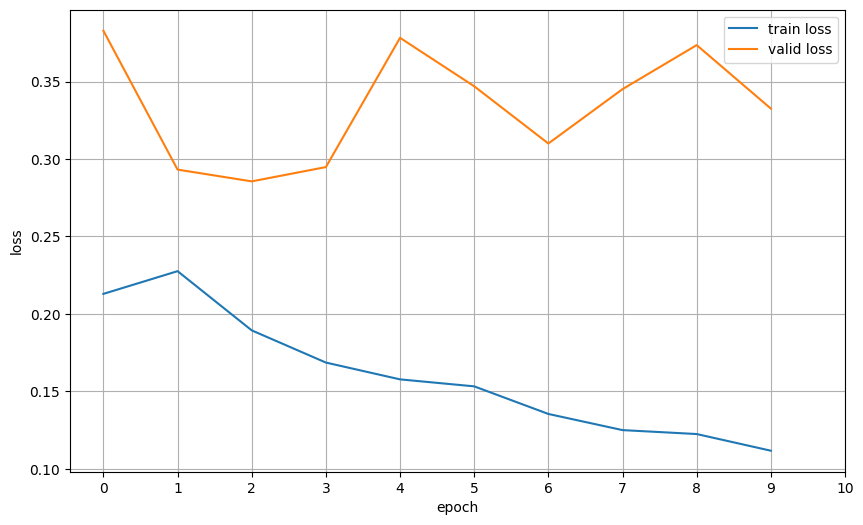

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs+1))
ax.legend()
ax.grid()

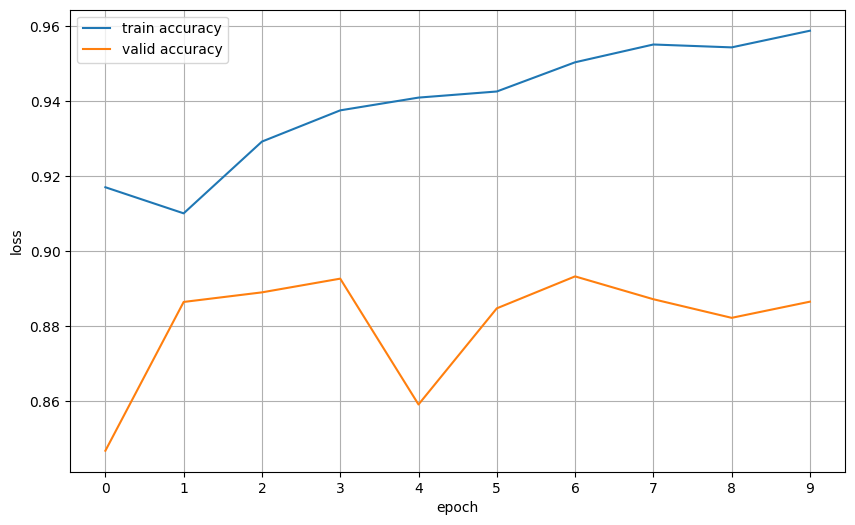

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 49/49 [00:14<00:00,  3.40it/s]


In [ ]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.299, test_acc: 0.875


In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9383718371391296)

In [ ]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9128222465515137)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.7179270386695862)

In [ ]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.6825625896453857)